In [ ]:
import warnings
# Silence the specific PyTorch/Dataloader warning
warnings.filterwarnings("ignore", message=".*pin_memory.*")
# Silence general UserWarnings to keep the output clean
warnings.filterwarnings("ignore", category=UserWarning)

: 

In [1]:
import os
import urllib.request

# Configuration
model_url = "https://huggingface.co/TheBloke/TinyLlama-1.1B-Chat-v1.0-GGUF/resolve/main/tinyllama-1.1b-chat-v1.0.Q4_K_M.gguf?download=true"
filename = "tinyllama-1.1b-chat-v1.0.Q4_K_M.gguf"

def download_model():
    if os.path.exists(filename):
        print(f" {filename} already exists!")
        return
    
    print(f" Downloading {filename} (637 MB)... This may take a minute.")
    try:
        urllib.request.urlretrieve(model_url, filename)
        print(" Download Complete!")
    except Exception as e:
        print(f" Download Failed: {e}")

download_model()

 Download Complete!


In [17]:
import sys
import torch
import os

print("--- DIAGNOSTIC REPORT ---")

# 1. Check Python Path (Should include .venv)
print(f"Python Environment: {sys.executable}")
if ".venv" in sys.executable:
    print(" Virtual Environment: ACTIVE")
else:
    print(" WARNING: You are NOT using the .venv kernel! (Select it in top-right)")

# 2. Check GPU
print(f"GPU Available: {torch.cuda.is_available()}")

# 3. Check Models
if os.path.exists("ui_model.pt"):
    print(" Vision Model (ui_model.pt): FOUND")
else:
    print(" Vision Model: NOT FOUND (Please copy your .pt file here)")

# 4. Check LLM
llm_filename = "tinyllama-1.1b-chat-v1.0.Q4_K_M.gguf"
if os.path.exists(llm_filename):
    print(f" LLM Model ({llm_filename}): FOUND")
else:
    print(f" LLM Model: NOT FOUND (Run the download script next)")

--- DIAGNOSTIC REPORT ---
Python Environment: c:\Users\janak\OneDrive\Desktop\UI_Evaluator\.venv\Scripts\python.exe
 Virtual Environment: ACTIVE
GPU Available: False
 Vision Model (ui_model.pt): FOUND
 LLM Model (tinyllama-1.1b-chat-v1.0.Q4_K_M.gguf): FOUND


In [7]:
import torch
import os
from ultralytics import YOLO
from ctransformers import AutoModelForCausalLM
from rule_engine import RuleEngine  

# --- 1. SETUP MODELS & ENGINE ---
print(" Loading System...")

# Load Vision (YOLO)
if os.path.exists("ui_model.pt"):
    vision_model = YOLO("ui_model.pt")
else:
    print(" ERROR: ui_model.pt not found!")

# Load LLM
llm = AutoModelForCausalLM.from_pretrained(
    "TheBloke/TinyLlama-1.1B-Chat-v1.0-GGUF",
    model_file="tinyllama-1.1b-chat-v1.0.Q4_K_M.gguf",
    model_type="llama",
    gpu_layers=0
)

# Initialize Rule Engine
engine = RuleEngine(excel_file="UI_RULE_SETS.xlsx")
print(" System Ready & Rules Engine Connected!")


# --- 2. THE RULE-AWARE JUDGE ---
def get_audit_summary(image_path, profile="universal"):
    """
    Runs YOLO, then checks against SPECIFIC rules from the CSV.
    """
    # Load the specific laws for this profile (e.g. "healthcare")
    engine.load_rules(profile)
    
    # Get the dynamic numbers
    MIN_BTN = engine.get("min_button_height")
    MIN_FIELD = engine.get("min_field_height")
    ALIGN_TOLERANCE = engine.get("max_misalignment")
    
    print(f" Enforcing {profile.upper()} Standards: Min Btn={MIN_BTN}px, Min Field={MIN_FIELD}px")

    # Run Vision
    results = vision_model(image_path, conf=0.3, verbose=False)
    
    if len(results[0].boxes) == 0:
        return None

    boxes = results[0].boxes.xyxy.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()
    
    stats = {
        "total": len(boxes),
        "small_btns": 0,
        "narrow_fields": 0,
        "misaligned": 0,
        "violations_list": []  # Keep a list for the LLM
    }
    
    centers = []

    for i, box in enumerate(boxes):
        cls_id = int(classes[i])
        y1, y2 = box[1], box[3]
        height = int(y2 - y1)
        centers.append(int((y1 + y2) / 2))
        
        # DYNAMIC RULE CHECK
        # Class 0 = Button
        if cls_id == 0 and height < MIN_BTN:
            stats["small_btns"] += 1
            stats["violations_list"].append(f"Button (ID {i}) is {height}px (Standard is {MIN_BTN}px)")
            
        # Class 2 = Field
        elif cls_id == 2 and height < MIN_FIELD:
            stats["narrow_fields"] += 1
            stats["violations_list"].append(f"Input (ID {i}) is {height}px (Standard is {MIN_FIELD}px)")

    # Alignment Check
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            diff = abs(centers[i] - centers[j])
            if 2 < diff < ALIGN_TOLERANCE + 5: # Little buffer
                stats["misaligned"] += 1

    return stats, f"""
    - AUDIT PROFILE: {profile.upper()}
    - Total Elements: {stats['total']}
    - CRITICAL: {stats['small_btns']} buttons failed the {MIN_BTN}px standard.
    - CRITICAL: {stats['narrow_fields']} inputs failed the {MIN_FIELD}px standard.
    - ALIGNMENT: {stats['misaligned']} issues found.
    """


# --- 3. THE INTERACTIVE CHAT LOOP ---
def start_consultation(image_path, profile="universal"):
    print(f"\n Analyzing {image_path} using {profile.upper()} Rules...")
    
    # 1. Run the Math Audit
    stats, summary_text = get_audit_summary(image_path, profile)
    
    if not stats:
        print(" No UI detected.")
        return

    # 2. Get Text Rules (Safety-Trimmed)
    # TRUNCATE: We only take the first 100 chars of each rule to save memory
    extra_context = ""
    if engine.text_rules:
        # Take only top 2 rules, and cut them short
        short_rules = [r[:100] + "..." if len(r) > 100 else r for r in engine.text_rules[:2]]
        extra_context = "\nPOLICY HIGHLIGHTS:\n" + "\n".join(f"- {r}" for r in short_rules)

    # 3. Create a COMPACT LLM Persona
    # We removed unnecessary fluff words to save space
    history = f"""
    Role: Senior UX Auditor. Topic: {profile} App.
    
    DATA:
    {summary_text}
    {extra_context}
    
    ERRORS:
    {stats['violations_list'][:2]}
    
    Task: Explain why these errors matter for {profile}. Mention the Policies if relevant.
    Keep it short (2 sentences max per point).
    """
    
    print("\n AI Consultant: (Analyzing Rules...)")
    
    # We lower max_new_tokens to leave room for the prompt
    response = llm(history, max_new_tokens=128, temperature=0.6)
    print(f" AI Consultant: {response}")
    
    # Chat Loop
    while True:
        user_input = input("\n👤 You (Type 'exit' to quit): ")
        if user_input.lower() in ['exit', 'quit']:
            print(" Session Ended.")
            break
            
        # Very short follow-up prompt
        prompt = f"""
        Context: {history[-200:]} 
        User: {user_input}
        Consultant:
        """
        
        print(" AI Consultant: (Thinking...)")
        response = llm(prompt, max_new_tokens=100, temperature=0.6)
        print(f" AI Consultant: {response}")
        
        # Only keep the last interaction to prevent memory overflow
        history = prompt + response

 Loading System...


Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


 System Ready & Rules Engine Connected!


In [8]:
import cv2
# Import your new module
from audit_utils import analyze_element_content 

# --- UPDATED AUDIT FUNCTION ---
def get_audit_summary(image_path, profile="universal"):
    
    engine.load_rules(profile)
    MIN_BTN = engine.get("min_button_height")
    
    # 1. Vision (YOLO)
    results = vision_model(image_path, conf=0.15, verbose=False)
    if len(results[0].boxes) == 0: return None, "No UI elements."

    # Load Image for Color Analysis
    original_img = cv2.imread(image_path)
    
    boxes = results[0].boxes.xyxy.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()
    
    stats = {"violations_list": [], "total": len(boxes)}
    
    print(f"🔍 Analyzing {len(boxes)} elements with deep inspection...")

    for i, box in enumerate(boxes):
        cls_id = int(classes[i])
        x1, y1, x2, y2 = map(int, box)
        height = y2 - y1
        
        # --- NEW: DEEP INSPECTION ---
        # Crop the element from the image
        # Safety check: ensure coordinates are within image
        h_img, w_img = original_img.shape[:2]
        crop = original_img[max(0,y1):min(h_img,y2), max(0,x1):min(w_img,x2)]
        
        # Analyze Colors & Text (Only if crop is valid)
        element_data = {"text": "", "contrast": 0}
        if crop.size > 0:
            element_data = analyze_element_content(crop)
        
        text_found = element_data.get("text", "Unknown")
        contrast = element_data.get("contrast")

        # --- JUDGE ---
        
        # 1. Size Check
        if cls_id == 0: # Button
            if height < MIN_BTN:
                stats["violations_list"].append(
                    f"Button '{text_found}' is too small ({height}px vs {MIN_BTN}px)."
                )
            
            # 2. Contrast Check (WCAG AA requires 4.5:1 for normal text)
            if contrast and contrast < 4.5:
                stats["violations_list"].append(
                    f"Accessibility: Button '{text_found}' has low contrast ({contrast}:1). Hard to read."
                )

    return stats, f"""
    - AUDIT PROFILE: {profile.upper()}
    - Total Elements Scanned: {stats['total']}
    - VIOLATIONS FOUND: {len(stats['violations_list'])}
    """

 Opening 'UI_RULE_SETS.xlsx' -> Sheet: 'Healthcare'...
 No pixel dimensions found. Using Defaults (44px).
   (This is normal if your Excel sheet only contains text policies like HIPAA)
🎨 Painting Analysis for HEALTHCARE (Min Height: 44px)...


d:\SMARTUI_RL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\SMARTUI_RL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\SMARTUI_RL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\SMARTUI_RL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\SMARTUI_RL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as t

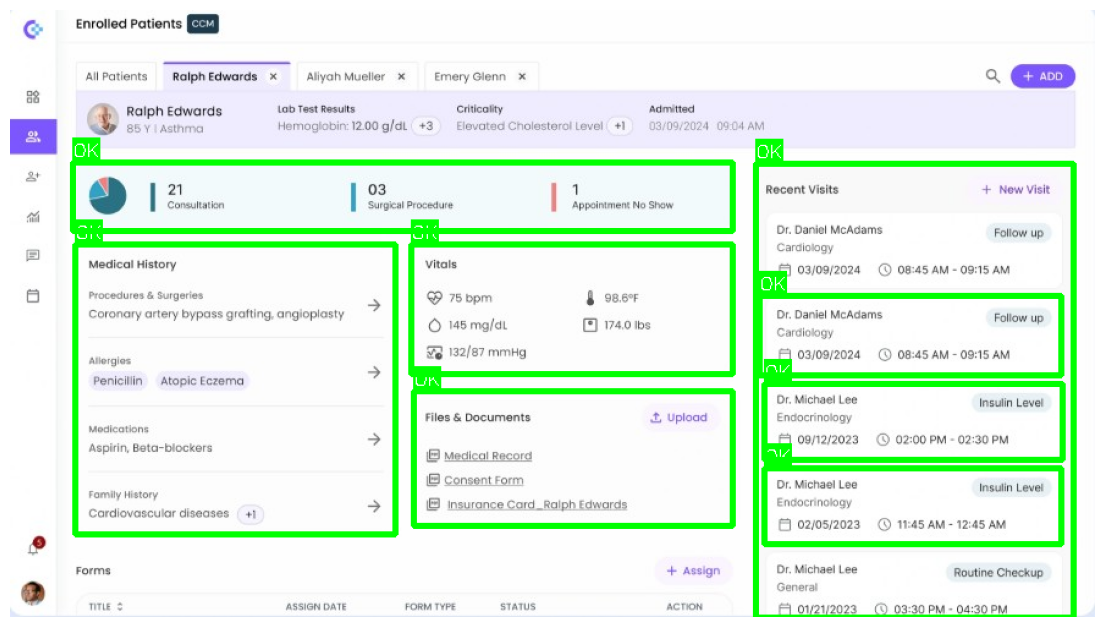

In [9]:
import cv2
import matplotlib.pyplot as plt
from audit_utils import analyze_element_content

def visualize_audit_advanced(image_path, profile="universal"):
    """
    Advanced Visualization:
    - RED Box = Error (Size, Contrast, or Risk)
    - GREEN Box = Pass
    - Labels show exactly WHY it failed.
    """
    # 1. Load Rules
    engine.load_rules(profile)
    MIN_BTN = engine.get("min_button_height")
    
    # 2. Run Vision
    results = vision_model(image_path, conf=0.15, verbose=False)
    if len(results[0].boxes) == 0:
        print("❌ No UI elements detected to visualize.")
        return

    # 3. Prepare Image
    original_img = cv2.imread(image_path)
    # Convert BGR (OpenCV) to RGB (Matplotlib)
    draw_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    boxes = results[0].boxes.xyxy.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()
    
    print(f"🎨 Painting Analysis for {profile.upper()} (Min Height: {MIN_BTN}px)...")

    for i, box in enumerate(boxes):
        cls_id = int(classes[i])
        x1, y1, x2, y2 = map(int, box)
        height = y2 - y1
        
        # Crop for Deep Analysis
        crop = original_img[max(0,y1):min(original_img.shape[0],y2), max(0,x1):min(original_img.shape[1],x2)]
        
        # Get Data (Text & Contrast)
        data = analyze_element_content(crop)
        text_lbl = data.get("text", "")
        contrast = data.get("contrast")
        
        # --- JUDGMENT LOGIC ---
        is_violation = False
        labels = []

        if cls_id == 0: # Button
            # Rule A: Size
            if height < MIN_BTN:
                is_violation = True
                labels.append(f"Too Small ({height}px)")
            
            # Rule B: Contrast
            if contrast and contrast < 3.0:
                is_violation = True
                labels.append(f"Low Contrast ({contrast}:1)")

        # --- DRAWING ---
        if is_violation:
            color = (255, 0, 0) # RED for Errors
            # Combine all errors into one label
            label_text = " | ".join(labels)
        else:
            color = (0, 255, 0) # GREEN for Pass
            label_text = "OK"

        # Draw Rectangle
        cv2.rectangle(draw_img, (x1, y1), (x2, y2), color, 3)
        
        # Draw Label Background (so text is readable)
        (w, h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(draw_img, (x1, y1 - 20), (x1 + w, y1), color, -1)
        
        # Draw Text
        cv2.putText(draw_img, label_text, (x1, y1 - 5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # 4. Show Final Image
    plt.figure(figsize=(14, 14))
    plt.imshow(draw_img)
    plt.axis('off')
    plt.show()

# --- EXECUTE ---
visualize_audit_advanced("test1.jpg", profile="healthcare")

 Opening 'UI_RULE_SETS.xlsx' -> Sheet: 'Healthcare'...
 No pixel dimensions found. Using Defaults (44px).
   (This is normal if your Excel sheet only contains text policies like HIPAA)
 Drawing boxes using HEALTHCARE standard (44px)...


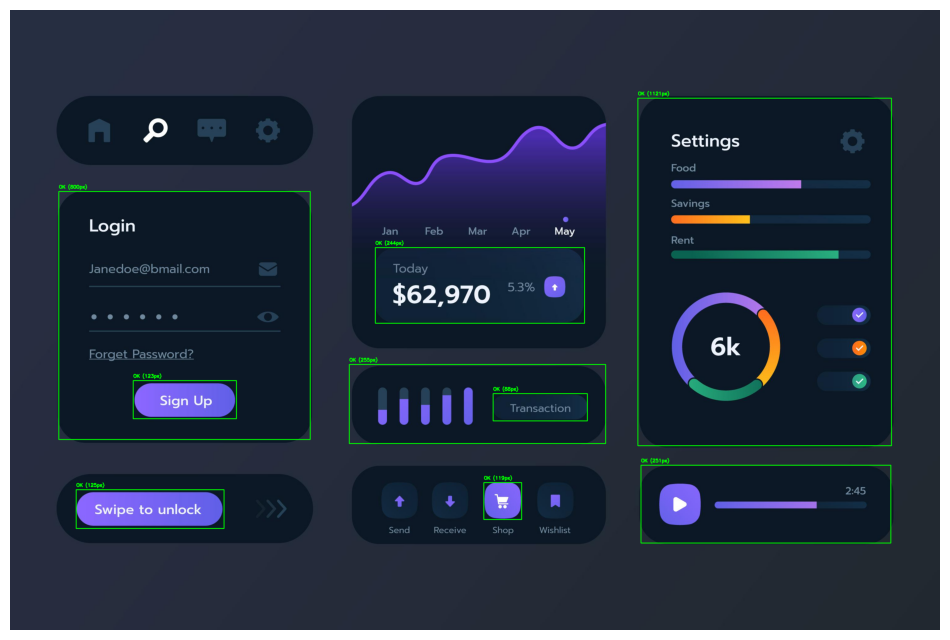

In [22]:
import cv2
import matplotlib.pyplot as plt

def visualize_errors(image_path, profile="universal"):
    """
    Draws RED boxes around errors and GREEN boxes around good elements.
    """
    # 1. Load Rules & Run Vision
    engine.load_rules(profile)
    MIN_BTN = engine.get("min_button_height")
    
    results = vision_model(image_path, conf=0.15, verbose=False)
    if len(results[0].boxes) == 0:
        print("No elements to visualize.")
        return

    # 2. Load Image with OpenCV
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert for Matplotlib
    
    boxes = results[0].boxes.xyxy.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()
    
    # 3. Draw Boxes
    print(f" Drawing boxes using {profile.upper()} standard ({MIN_BTN}px)...")
    
    for i, box in enumerate(boxes):
        cls_id = int(classes[i])
        x1, y1, x2, y2 = map(int, box)
        height = y2 - y1
        
        # COLOR LOGIC: Red = Error, Green = OK
        color = (0, 255, 0) # Green
        label = f"OK ({height}px)"
        
        if cls_id == 0: # Button
            if height < MIN_BTN:
                color = (255, 0, 0) # Red
                label = f"TOO SMALL ({height}px)"
        
        # Draw Box & Label
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # 4. Show Image
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# --- RUN IT ---
visualize_errors("test1.jpg", profile="healthcare")

In [11]:
import pandas as pd

# Load the raw sheet without any processing
print("--- RAW EXCEL DIAGNOSTIC ---")
try:
    df = pd.read_excel("UI_RULE_SETS.xlsx", sheet_name="Healthcare", header=None)
    print("First 5 rows of data:")
    print(df.head())
except Exception as e:
    print(f"Error reading file: {e}")

--- RAW EXCEL DIAGNOSTIC ---
First 5 rows of data:
            0                                  1  \
0     Rule ID                          Rule Name   
1  HEALTH-001                HIPAA Compliance UI   
2  HEALTH-002  Clear Medical Information Display   
3  HEALTH-003           Critical Alert Hierarchy   
4  HEALTH-004           Medication Safety Checks   

                                                   2  
0                                        Description  
1  Design with privacy-first approach. Auto-logou...  
2  Present medical data clearly with proper units...  
3  Distinguish between informational, warning, an...  
4  Implement double-checks for medication orders....  


In [10]:
from rl_feedback import FeedbackLearner
from audit_utils import analyze_element_content
import cv2

# Initialize the Brain
learner = FeedbackLearner()

def start_training_session_debug(image_path, profile="healthcare"):
    print(f"\n🎓 Starting RL Training Session for {profile.upper()}...")
    
    # 1. Load Rules
    engine.load_rules(profile)
    
    # --- DEBUG: FORCE STRICT RULE ---
    # We ignore the Excel file for a moment and force a 100px requirement
    print("🔧 DEBUG MODE: Forcing Min Button Height to 100px to trigger RL...")
    MIN_BTN = 100 
    
    results = vision_model(image_path, conf=0.15, verbose=False)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()
    
    violations_found = 0
    buttons_found = 0
    
    for i, box in enumerate(boxes):
        cls_id = int(classes[i])
        y1, y2 = int(box[1]), int(box[3])
        height = y2 - y1
        
        if cls_id == 0: # Button
            buttons_found += 1
            is_violation = height < MIN_BTN
            
            if is_violation:
                rule_name = "min_button_height"
                
                # Check RL Memory
                should_flag = learner.should_flag_violation(profile, rule_name)
                
                if should_flag:
                    violations_found += 1
                    print(f"\n⚠️ VIOLATION: Button #{i} is {height}px (Target: {MIN_BTN}px)")
                    print("🤖 AI: This is too small. Should I flag this?")
                    
                    # USER INTERACTION
                    user_input = input("👤 You ('y' = Good Catch, 'n' = Ignore this rule): ").lower().strip()
                    
                    if user_input == 'y':
                        print(learner.update_policy(profile, rule_name, +1))
                    elif user_input == 'n':
                        print(learner.update_policy(profile, rule_name, -1))
                    else:
                        print("Skipped.")
                else:
                    print(f"\n(Silent: I ignored a {height}px button because you trained me to.)")
    
    if buttons_found == 0:
        print("❌ DEBUG: No buttons detected at all. Check YOLO model.")
    elif violations_found == 0:
        print("✅ No violations found (RL has silenced them all).")

# --- RUN IT ---
start_training_session_debug("test1.jpg", profile="healthcare")


🎓 Starting RL Training Session for HEALTHCARE...
 Opening 'UI_RULE_SETS.xlsx' -> Sheet: 'Healthcare'...
 No pixel dimensions found. Using Defaults (44px).
   (This is normal if your Excel sheet only contains text policies like HIPAA)
🔧 DEBUG MODE: Forcing Min Button Height to 100px to trigger RL...
❌ DEBUG: No buttons detected at all. Check YOLO model.


In [11]:
import json
import datetime
import cv2
import numpy as np
import os
from ultralytics import YOLO
from rule_engine import RuleEngine
from rl_feedback import FeedbackLearner
from audit_utils import analyze_element_content

# --- 1. INITIALIZE SYSTEM COMPONENTS ---
print("⚙️ Initializing System...")

# A. Load Vision Model
if os.path.exists("ui_model.pt"):
    vision_model = YOLO("ui_model.pt")
    print("✅ Vision Model Loaded.")
else:
    print("❌ ERROR: ui_model.pt not found!")

# B. Load Rule Engine
if os.path.exists("UI_RULE_SETS.xlsx"):
    engine = RuleEngine(excel_file="UI_RULE_SETS.xlsx")
    print("✅ Rule Engine Loaded.")
else:
    print("❌ ERROR: UI_RULE_SETS.xlsx not found!")
    engine = None

# C. Load RL Learner
learner = FeedbackLearner()
print("✅ RL Agent Loaded.")

# --- 2. HELPER FUNCTIONS ---
def convert_for_json(obj):
    """Converts Numpy types to standard Python types for JSON saving."""
    if isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    if isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

# --- 3. THE MAIN AUDIT FUNCTION ---
def generate_full_audit_json(image_path, profile="healthcare", output_file="audit_result.json"):
    print(f"\n🚀 Starting Full Audit for {profile.upper()}...")
    
    if not engine:
        print("❌ Engine not initialized. Cannot proceed.")
        return

    # 1. Load Specific Rules
    engine.load_rules(profile) 
    MIN_BTN = engine.get("min_button_height")
    print(f"📏 Enforcing Rule: Min Button Height = {MIN_BTN}px")
    
    # 2. Run Vision Scan
    results = vision_model(image_path, conf=0.15, verbose=False)
    
    # Check if image exists
    if not os.path.exists(image_path):
        print(f"❌ Error: Image '{image_path}' not found.")
        return

    original_img = cv2.imread(image_path)
    
    if len(results[0].boxes) == 0:
        print("❌ No UI elements detected.")
        return None

    # 3. Build JSON Structure
    audit_report = {
        "meta": {
            "timestamp": str(datetime.datetime.now()),
            "image_file": image_path,
            "profile_used": profile,
            "rules_enforced": engine.current_rules
        },
        "summary": {
            "total_elements": 0,
            "violations_found": 0,
            "score": 100
        },
        "elements": []
    }

    boxes = results[0].boxes.xyxy.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()
    
    print(f"🔍 Analyzing {len(boxes)} elements...")

    # 4. Iterate & Analyze
    for i, box in enumerate(boxes):
        cls_id = int(classes[i])
        x1, y1, x2, y2 = map(int, box)
        height = y2 - y1
        
        # Deep Analysis (OCR/Contrast)
        h_img, w_img = original_img.shape[:2]
        crop = original_img[max(0,y1):min(h_img,y2), max(0,x1):min(w_img,x2)]
        
        # Safe Crop Check
        if crop.size == 0:
            continue
            
        data = analyze_element_content(crop)
        
        element_record = {
            "id": i,
            "type": "button" if cls_id == 0 else "input",
            "bbox": [x1, y1, x2, y2],
            "dimensions": {"width": x2-x1, "height": height},
            "content": data, # Includes Text and Contrast
            "issues": [],
            "status": "PASS"
        }
        
        # --- RULE CHECKING ---
        violations = []
        
        if cls_id == 0: # Button Rules
            # Rule 1: Size
            if height < MIN_BTN:
                violations.append({
                    "rule": "min_button_height",
                    "description": f"Height is {height}px (Required: {MIN_BTN}px)",
                    "severity": "high"
                })
            
            # Rule 2: Contrast (Standard WCAG limit is 3.0 for UI components)
            if data["contrast"] and data["contrast"] < 3.0:
                violations.append({
                    "rule": "contrast_ratio",
                    "description": f"Contrast is {data['contrast']}:1 (Required: 3.0:1)",
                    "severity": "medium"
                })

        # --- RL FILTERING (The Brain) ---
        active_issues = []
        for v in violations:
            rule_name = v["rule"]
            
            # Ask RL: "Does the user care about this rule?"
            if learner.should_flag_violation(profile, rule_name):
                active_issues.append(v)
            else:
                # We log it as silenced so you know why it didn't count
                v["status"] = "SILENCED_BY_USER_PREFERENCE"
                # Optional: element_record["issues"].append(v) 

        # Finalize Element Status
        if len(active_issues) > 0:
            element_record["status"] = "FAIL"
            element_record["issues"] = active_issues
            audit_report["summary"]["violations_found"] += 1
            audit_report["summary"]["score"] -= (5 * len(active_issues))
        
        audit_report["elements"].append(element_record)

    # 5. Final Calculations
    audit_report["summary"]["total_elements"] = len(audit_report["elements"])
    audit_report["summary"]["score"] = max(0, int(audit_report["summary"]["score"]))

    # 6. Save to File
    with open(output_file, 'w') as f:
        json.dump(audit_report, f, indent=4, default=convert_for_json)
        
    print(f"✅ Audit Complete! Results saved to: {output_file}")
    print(f"📊 Final Score: {audit_report['summary']['score']}/100")
    return audit_report

# --- 4. EXECUTE ---
final_json = generate_full_audit_json("test1.jpg", profile="healthcare")

⚙️ Initializing System...
✅ Vision Model Loaded.
✅ Rule Engine Loaded.
✅ RL Agent Loaded.

🚀 Starting Full Audit for HEALTHCARE...
 Opening 'UI_RULE_SETS.xlsx' -> Sheet: 'Healthcare'...
 No pixel dimensions found. Using Defaults (44px).
   (This is normal if your Excel sheet only contains text policies like HIPAA)
📏 Enforcing Rule: Min Button Height = 44px
🔍 Analyzing 8 elements...


d:\SMARTUI_RL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\SMARTUI_RL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\SMARTUI_RL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\SMARTUI_RL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\SMARTUI_RL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as t

✅ Audit Complete! Results saved to: audit_result.json
📊 Final Score: 100/100


In [ ]:
import json
import datetime
import cv2
import numpy as np
from rl_feedback import FeedbackLearner
from audit_utils import analyze_element_content
from metrics_tracker import AuditMetrics, calculate_rl_accuracy  # ← ADD THIS LINE

# INITIALIZE METRICS TRACKER GLOBALLY
metrics_tracker = AuditMetrics()

def generate_audit_nuclear(image_path, profile="gaming", output_file="audit_result.json"):
    print(f"\n🔍 STARTING AUDIT FOR {profile.upper()}...")
    
    learner = FeedbackLearner()
    MIN_BTN = 200
    
    # Vision Scan
    results = vision_model(image_path, conf=0.15, verbose=False)
    original_img = cv2.imread(image_path)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    
    audit_report = {
        "meta": {"timestamp": str(datetime.datetime.now()), "profile": profile},
        "summary": {"score": 100, "violations": 0},
        "elements": []
    }
    
    user_feedbacks = []  # Track all user responses
    
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        height = y2 - y1
        width = x2 - x1
        
        crop = original_img[max(0,y1):min(original_img.shape[0],y2), 
                           max(0,x1):min(original_img.shape[1],x2)]
        data = analyze_element_content(crop)

        element_record = {
            "id": i,
            "type": "detected_object",
            "bbox": [x1, y1, x2, y2],
            "content": data,
            "issues": [],
            "status": "PASS"
        }
        
        # Check violation
        if height < MIN_BTN:
            violation = {"rule": "min_height", "desc": f"Height {height}px < {MIN_BTN}px"}
            
            if learner.should_flag_violation(profile, "universal_min_height"):
                print(f"  VIOLATION: '{data.get('text')}' is {height}px.")
                user_input = input(" AI: Flag this? (y/n): ").lower().strip()
                
                if user_input == 'y':
                    learner.update_policy(profile, "universal_min_height", +1)
                    element_record["status"] = "FAIL"
                    element_record["issues"].append(violation)
                    audit_report["summary"]["violations"] += 1
                    audit_report["summary"]["score"] -= 5
                    user_feedbacks.append(("universal_min_height", 1))  # Accepted
                else:
                    learner.update_policy(profile, "universal_min_height", -1)
                    element_record["status"] = "IGNORED_BY_USER"
                    user_feedbacks.append(("universal_min_height", -1))  # Rejected
            else:
                element_record["status"] = "SILENCED_BY_RL"

        audit_report["elements"].append(element_record)

    # Save audit
    with open(output_file, 'w') as f:
        json.dump(audit_report, f, indent=4, default=lambda o: int(o) if isinstance(o, (np.int64, np.int32)) else str(o))
    
    # TRACK METRICS
    run_metrics = metrics_tracker.record_run(audit_report, user_feedbacks)
    print(f"\n RUN METRICS:")
    print(json.dumps(run_metrics, indent=2))
    
    # Show improvement if multiple runs
    if len(metrics_tracker.runs) > 1:
        improvement = metrics_tracker.get_improvement_metrics()
        print(f"\n LEARNING PROGRESS:")
        print(json.dumps(improvement, indent=2))
    
    print(f"\n Saved to {output_file}")
    
    return audit_report

# RUN MULTIPLE TIMES TO SEE LEARNING
generate_audit_nuclear("test1.jpg", profile="healthcare")
generate_audit_nuclear("test2.jpg", profile="healthcare")
generate_audit_nuclear("test3.jpg", profile="healthcare")

# GET FINAL STATS
learner = FeedbackLearner()
print("\n" + "="*60)
print(" FINAL RL LEARNING STATISTICS")
print("="*60)
print(json.dumps(calculate_rl_accuracy(learner), indent=2))

print("\n" + "="*60)
print(" OVERALL IMPROVEMENT METRICS")
print("="*60)
print(json.dumps(metrics_tracker.get_improvement_metrics(), indent=2))

# Save all metrics
metrics_tracker.save_metrics()


☢️ STARTING NUCLEAR AUDIT FOR HEALTHCARE...
 Opening 'UI_RULE_SETS.xlsx' -> Sheet: 'Healthcare'...
 No pixel dimensions found. Using Defaults (44px).
   (This is normal if your Excel sheet only contains text policies like HIPAA)


d:\SMARTUI_RL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


⚠️ VIOLATION: 'Files Documonte upload DMedlcal Record ~onseni-Orn Insurance Cord_Ralph Edwards' is 110px.


d:\SMARTUI_RL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


⚠️ VIOLATION: 'vitols 75 Dpm 98,62F 145 mgldl 174,0 Ibs 132/87 mmHg' is 106px.


d:\SMARTUI_RL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\SMARTUI_RL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\SMARTUI_RL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


⚠️ VIOLATION: 'Conutcn AJr0ca Dron unt Appainlniem: No Shjn' is 56px.


d:\SMARTUI_RL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


⚠️ VIOLATION: 'Dr: Kichael Lee Insulin Level Encocnnology 02/05/2023 1145 AM - 12.45 Av' is 62px.


d:\SMARTUI_RL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


⚠️ VIOLATION: 'Dr; Michael Lee InsMiin Levei Enqocnino D0 09/12/2023 02Q0 PM 02;30 PM' is 62px.


d:\SMARTUI_RL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


⚠️ VIOLATION: 'Dr: Daniel McAdams Follaw Cardio O9Y 03/09/2024 08.45 AM 09.15 AM' is 65px.
✅ Saved to audit_result.json
